# Информация о датасете
1. Данные об использовании смартфонов. Датасет был взят с сайта www.kagle.com по [ссылке](https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset). Датасет был сгенерирован искуственно.
2. В датасете представлены следующие атрибуты:
 - User ID - идентификатор пользователя
 - Operating System - Android или iOS
 - App Usage Time (min/day) - использование приложений (мин в день)
 - Screen On Time (hours/day) - время включенного экрана смартфона (часов в день)
 - Battery Drain (mAh/day) - разряд батареи в сутки
 - Number of Apps Installed - количество установленных приложений
 - Data Usage (MB/day) - использование сети в мб в день
 - Age - возраст
 - Gender - Пол
 - User Behavior Class - классификация поведения пользователя. Целевой класс

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings 

warnings.filterwarnings('ignore')

df = pd.read_csv('user_behavior_dataset.csv')
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


# Обработка датасета

## Преобразуем датасет
- Удалим Device Model, Operating System, Gender
- Переименуем App Usage Time (min/day) в Usage Time, Screen On Time (hours/day) в Screen Time, Battery Drain (mAh/day) в Battery Drain, Data Usage (MB/day) в Data Usage
- Преобразуем App Usage Time в часы/день

In [5]:
def minutes_to_hours(minutes):
    return minutes / 60

df.drop(columns=['User ID', 'Device Model', 'Operating System', 'Gender'], inplace=True)
df.rename(columns={'App Usage Time (min/day)': 'Usage Time', 'Screen On Time (hours/day)': 'Screen Time', 'Battery Drain (mAh/day)': 'Battery Drain', 'Data Usage (MB/day)': 'Data Usage'}, inplace=True)
df['Usage Time'] = df['Usage Time'].apply(minutes_to_hours)

## Почистим датасет
- Удалим выбросы
- Удалим дубликаты
- Заполним пропуски

In [7]:
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers
def delete_outliers(data, column): 
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data
def fill_gaps(data, column):
    return data

In [8]:
duplicates = df.duplicated().sum()
if duplicates:
    df = df.drop_duplicates()
    print(f'Удалено {duplicates} дубликатов.')
else:
    print(f'В наборе нет дубликатов')
sum_gaps = 0
sum_outliers = 0
for column in df.columns:
    gaps = df[column].isna().sum()
    sum_gaps += gaps
    if gaps:
        df = fill_gaps(df, column)
    outliers = len(detect_outliers(df[column]))
    sum_outliers += outliers
    if outliers:
        df = delete_outliers(df, column)
if sum_gaps:
    print(f'Заполнено {sum_gaps} пропущенных значений.')
else:
    print(f'В наборе нет пропущенных значений.')
if sum_outliers:
    print(f'Удалено {sum_outliers} выбросов.')
else:
    print(f'В наборе нет выбросов.')

В наборе нет дубликатов
В наборе нет пропущенных значений.
В наборе нет выбросов.


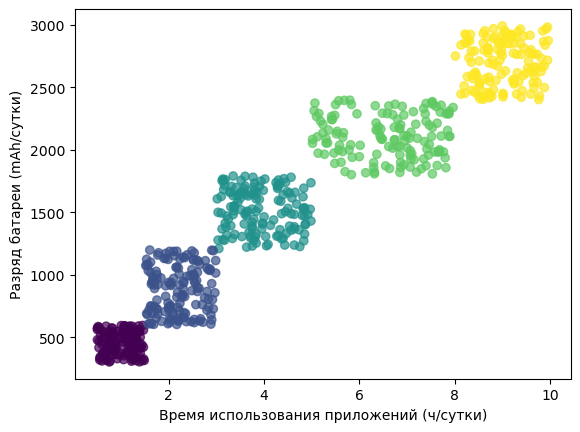

In [9]:
plt.scatter(df['Usage Time'], df['Battery Drain'], alpha=0.7, c=df['User Behavior Class'])
plt.xlabel('Время использования приложений (ч/сутки)')
plt.ylabel('Разряд батареи (mAh/сутки)')
plt.show()

# Применение алгоритмов классификации


## Подготовим данные

In [12]:
y = df['User Behavior Class']
X = df.drop('User Behavior Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Применение метода k-ближайших соседей (kNN)

In [14]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
knn_y_pred_proba = knn_model.predict_proba(X_test)

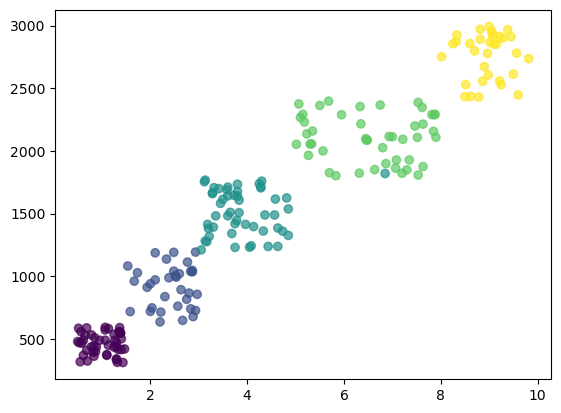

In [15]:
plt.scatter(X_test['Usage Time'], X_test['Battery Drain'], c=knn_y_pred, alpha=0.7)

## Применение метода Дерева Решений

In [17]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)
dt_y_pred_proba = dt_model.predict_proba(X_test)

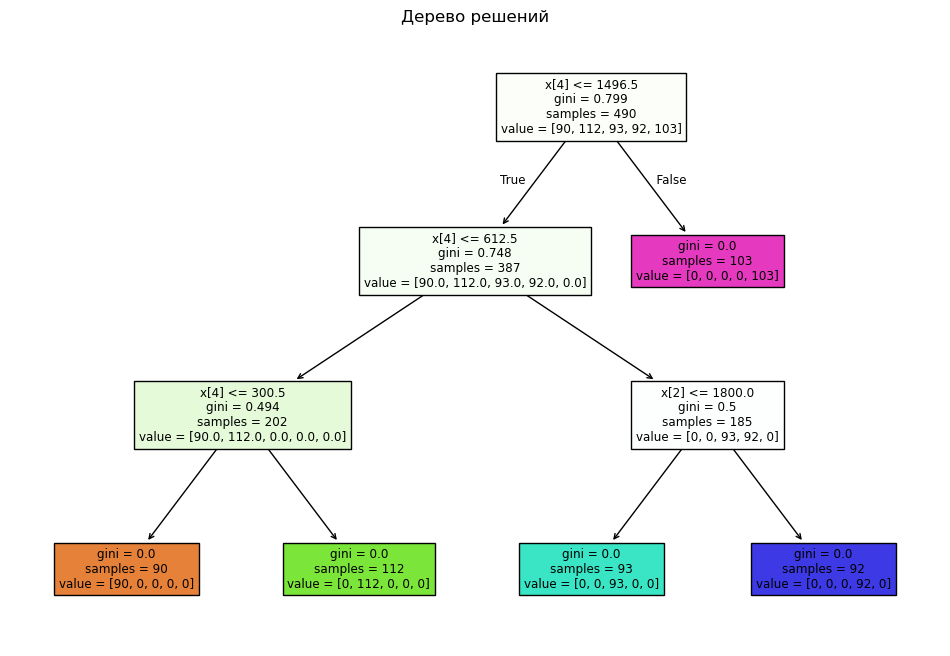

In [18]:
from sklearn import tree
plt.figure(figsize=(12,8))
tree.plot_tree(dt_model, filled=True)
plt.title("Дерево решений")
plt.show()

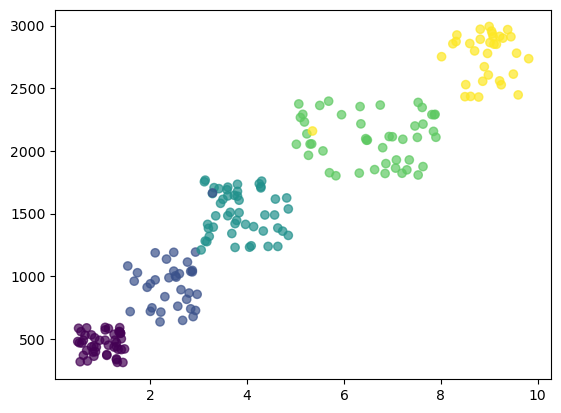

In [19]:
plt.scatter(X_test['Usage Time'], X_test['Battery Drain'], c=dt_y_pred, alpha=0.7)

__В целом, видно, что оба алгоритма справились с поставленной задачей примерно одинаково: наглядно видно по одной ошибке-две ошибки после работы каждого алгоритма__

# Использование метрик оценки качества

## Accuracy

In [23]:
print(f'Accuracy для kNN: {accuracy_score(y_test, knn_y_pred)}')
print(f'Accuracy для Decision Tree: {accuracy_score(y_test, dt_y_pred)}')

Accuracy для kNN: 0.9952380952380953
Accuracy для Decision Tree: 0.9904761904761905


## Precision

In [25]:
print(f'Precision для kNN: {precision_score(y_test, knn_y_pred, average='micro')}')
print(f'Precision для Decision Tree: {precision_score(y_test, dt_y_pred, average='micro')}')

Precision для kNN: 0.9952380952380953
Precision для Decision Tree: 0.9904761904761905


## Recall

In [27]:
print(f'Recall для kNN: {recall_score(y_test, knn_y_pred, average='micro')}')
print(f'Recall для Decision Tree: {recall_score(y_test, dt_y_pred, average='micro')}')

Recall для kNN: 0.9952380952380953
Recall для Decision Tree: 0.9904761904761905


## F-Measure

In [29]:
print(f'F-Measure для kNN: {f1_score(y_test, knn_y_pred, average='micro')}')
print(f'F-Measure для Decision Tree: {f1_score(y_test, dt_y_pred, average='micro')}')

F-Measure для kNN: 0.9952380952380953
F-Measure для Decision Tree: 0.9904761904761905


## ROC

In [31]:
knn_roc_auc = roc_auc_score(y_test, knn_y_pred_proba, multi_class='ovr') 
dt_roc_auc = roc_auc_score(y_test, dt_y_pred_proba, multi_class='ovr')
print(f'ROC для kNN: {knn_roc_auc}')
print(f'ROC для Decision Tree: {dt_roc_auc}')

ROC для kNN: 1.0
ROC для Decision Tree: 0.9947391868559377
